In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import joblib

# Reading Dataset

In [2]:
df = pd.read_csv("car_data.csv")
print(df.shape)
df.head()

(8128, 13)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


# Preprocessing Dataset

In [3]:
# Drop rows with missing values
df.dropna(inplace=True)

# Convert mileage, engine, and max_power to float
df['mileage'] = df['mileage'].str.replace(' kmpl','').str.replace(' km/kg','').astype(float)
df['engine'] = df['engine'].str.replace(' CC','').astype(float)
df['max_power'] = df['max_power'].str.replace(' bhp','').astype(float)

# Drop 'torque' as it's messy text and hard to parse meaningfully
df.drop(columns=['torque'], inplace=True)


In [4]:
# Age of the car
df['car_age'] = 2025 - df['year']
df.drop(columns=['year'], inplace=True)

# Encode Categorical Columns with LabelEncoder
categorical_cols = ['fuel', 'seller_type', 'transmission', 'owner']
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le  # Save encoder for deployment


In [5]:
df.head()

,name,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,seats,car_age
0,Maruti Swift Dzire VDI,450000,145500,1,1,1,0,23.40,1248.0,74.00,5.0,11
1,Skoda Rapid 1.5 TDI Ambition,370000,120000,1,1,1,2,21.14,1498.0,103.52,5.0,11
2,Honda City 2017-2020 EXi,158000,140000,3,1,1,4,17.70,1497.0,78.00,5.0,19
3,Hyundai i20 Sportz Diesel,225000,127000,1,1,1,0,23.00,1396.0,90.00,5.0,15
4,Maruti Swift VXI BSIII,130000,120000,3,1,1,0,16.10,1298.0,88.20,5.0,18


# Train Test split

In [6]:
# Features and Target
X = df.drop(columns=['name', 'selling_price'])  # drop car name (too noisy)
y = df['selling_price']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Save encoders for FastAPI deployment)
joblib.dump(encoders, 'label_encoders.pkl')
joblib.dump(X.columns.tolist(), 'model_features.pkl')

['model_features.pkl']

# Randomized Search CV

In [15]:
param_grid = {
    'n_estimators': [10,30,50,100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}


In [16]:
from sklearn.model_selection import RandomizedSearchCV

# Random Forest model
rf = RandomForestRegressor(random_state=42)

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit on training data
random_search.fit(X_train, y_train)

# Best estimator
best_rf = random_search.best_estimator_

print("Best Params:", random_search.best_params_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None}


# Random Forest Regressor

In [19]:
best_params = random_search.best_params_

final_model = RandomForestRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    max_features=best_params['max_features'],
    random_state=42
)

# Train final model
final_model.fit(X_train, y_train)

RandomForestRegressor(max_features=None, random_state=42)

In [20]:
# Save the final model
joblib.dump(final_model, 'car_price_model_tuned.pkl')

['car_price_model_tuned.pkl']

# Evaluate

In [21]:
# Evaluate
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Final Tuned Model Results:")
print("RMSE:", rmse)
print("R² Score:", r2)

Final Tuned Model Results:
RMSE: 107014.8468211808
R² Score: 0.9835287548058553


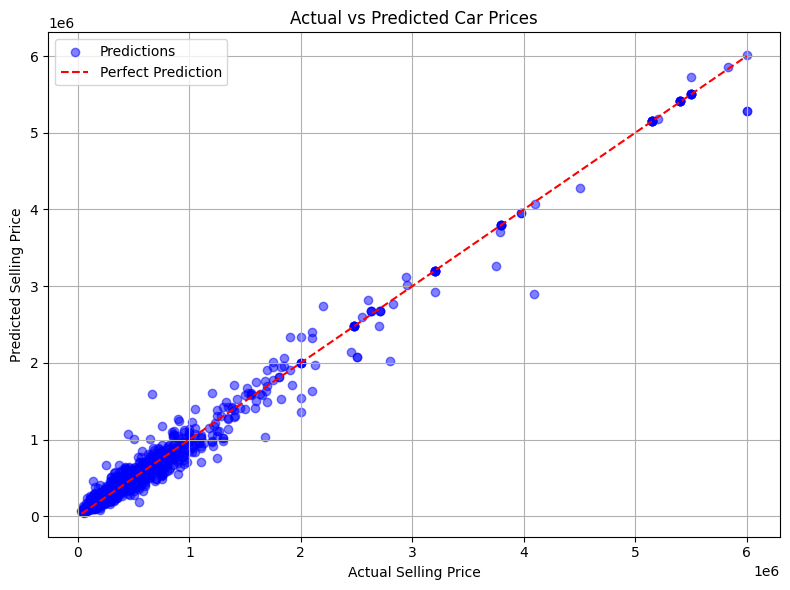

In [22]:
# Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label='Predictions')

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Perfect Prediction')

# Labels and Title
plt.xlabel('Actual Selling Price')
plt.ylabel('Predicted Selling Price')
plt.title('Actual vs Predicted Car Prices')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
